<a href="https://colab.research.google.com/github/HarounH/smol/blob/main/rl/hello_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Hello RL
# https://chatgpt.com/c/690beda9-a39c-832b-b88b-9d016b9e1179

In [3]:
# @title Q Learning

import gymnasium
import tensorflow as tf
import numpy as np
from collections import deque
from dataclasses import dataclass
import io
import base64
import io
import base64
import optax

import numpy as np
import imageio.v2 as imageio
from IPython.display import HTML
import jax.numpy as jnp


def show_mp4_from_frames_imageio(frames, fps=30):
    """
    Display a list of (H, W, 3) RGB frames inline as an MP4 <video> in Jupyter,
    using only in-memory buffers on the Python side (no explicit temp files).

    Args:
        frames: list/array of frames, each (H, W, 3), RGB.
                float frames are assumed in [0, 1]; others are clipped to [0, 255].
        fps: frames per second.

    Returns:
        IPython.display.HTML object.
    """
    if not frames:
        raise ValueError("frames list is empty")

    norm_frames = []
    for f in frames:
        f = np.asarray(f)
        if f.ndim != 3 or f.shape[-1] != 3:
            raise ValueError(f"Each frame must be (H, W, 3), got {f.shape}")
        if f.dtype != np.uint8:
            if np.issubdtype(f.dtype, np.floating):
                f = np.clip(f, 0.0, 1.0)
                f = (f * 255).astype(np.uint8)
            else:
                f = np.clip(f, 0, 255).astype(np.uint8)
        norm_frames.append(f)

    # Encode MP4 into an in-memory buffer
    buf = io.BytesIO()
    # 'mp4' picks the ffmpeg writer; you can also try format="FFMPEG"
    imageio.mimsave(buf, norm_frames, format="mp4", fps=fps)
    buf.seek(0)
    video_bytes = buf.read()

    b64 = base64.b64encode(video_bytes).decode("ascii")

    html = f"""
    <video controls loop>
        <source src="data:video/mp4;base64,{b64}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """

    return HTML(html)


In [4]:
def make_env():
    return gymnasium.make("CartPole-v1", render_mode="rgb_array")
env = make_env()
_ = env.reset()
n_steps = 100
frames = []
for step_id in range(n_steps):
    frame = env.render()
    frames.append(frame)
    random_action = env.action_space.sample()
    new_state, reward, terminated, truncated, info = env.step(random_action)

    if terminated or truncated:
        break

show_mp4_from_frames_imageio(frames)

In [5]:
class Memory:
    def __init__(self, max_size: int = 1000):
        self.data = deque(maxlen=max_size)

    def append(self, item):
        self.data.append(item)

    def sample(self, batch_size: int = 4):
        indices = np.random.randint(0, len(self.data), batch_size)
        return [self.data[idx] for idx in indices]

_memory = Memory(4)
[_memory.append(x) for x in [1, 2, 3, 4, 5, 6, 7]]
print(_memory.data)
print(_memory.sample(3))

deque([4, 5, 6, 7], maxlen=4)
[7, 4, 7]


In [6]:
from flax import nnx


class Layer(nnx.Module):
    def __init__(self, dim: int, expansion: int, rngs: nnx.Rngs):
        self.fc1 = nnx.Linear(dim, dim * expansion, rngs=rngs)
        self.fc2 = nnx.Linear(dim * expansion, dim, rngs=rngs)

    def __call__(self, x):
        z = self.fc1(x)
        z = jax.nn.relu(z)
        z = self.fc2(z)
        return z


class QNet(nnx.Module):
    def __init__(self, dim_in: int = 4, d_model: int = 32, num_actions: int = 2, num_layers: int = 2, rngs: nnx.Rngs | None = None):
        self.in_proj = nnx.Linear(dim_in, d_model, rngs=rngs)
        self.out_proj = nnx.Linear(d_model, num_actions, rngs=rngs)
        self.layers = [Layer(d_model, 2, rngs) for _layer_idx in range(num_layers)]

    def __call__(self, x):
        z = self.in_proj(x)
        for layer in self.layers:
            z = layer(z)
        z = self.out_proj(z)
        return z

Step 251/10000, loss=2.0632


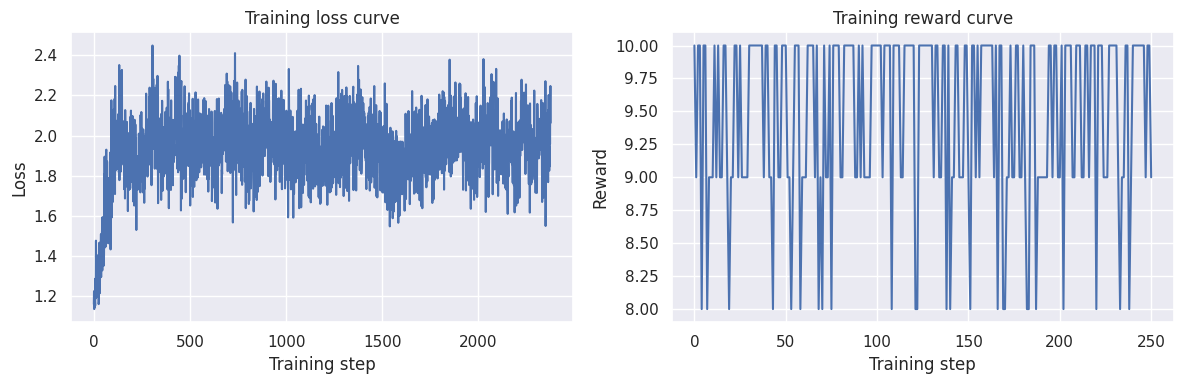

KeyboardInterrupt: 

In [10]:
import jax
from flax import struct
from tqdm import trange
import orbax.checkpoint as ocp



@dataclass
class Params:
    memory_bank_size: int = 100
    memory_prefill_episode_count: int = 10
    batch_size: int = 24
    num_training_steps: int = 100
    max_episode_length: int = 100
    seed: int = 1337

    discount_rate: float = 0.99
    exploration_probability: float = 0.1

    d_model: int = 64
    n_layers: int = 3

    lr: float = 1e-3

    ckpt_dir: str = '/tmp/checkpoints/'
@struct.dataclass
class Datum:
    s_t: jax.Array
    a_t: jax.Array
    r_t: jax.Array
    s_tp1: jax.Array


@struct.dataclass
class Batch:
    # TODO: type hint as JAX array likes?
    s_t_BD: jax.Array
    a_t_B: jax.Array
    r_t_B: jax.Array
    s_tp1_BD: jax.Array

    @classmethod
    def from_list(cls, datums: list[Datum]) -> "Batch":
        s_t_BD = jnp.stack([d.s_t for d in datums])
        a_t_B = jnp.stack([d.a_t for d in datums])
        r_t_B = jnp.stack([d.r_t for d in datums])
        s_tp1_BD = jnp.stack([d.s_tp1 for d in datums])
        return Batch(
            s_t_BD=s_t_BD,
            a_t_B=a_t_B,
            r_t_B=r_t_B,
            s_tp1_BD=s_tp1_BD,
        )

params = Params(num_training_steps=10000, max_episode_length=10, lr=1e-4)
rngs = nnx.Rngs(default=params.seed)

num_actions = env.action_space.n
dim_in = env.observation_space.shape[0]

qnet = QNet(dim_in, params.d_model, num_actions, params.n_layers, rngs)
optimizer = nnx.Optimizer(qnet, optax.adamw(params.lr), wrt=nnx.Param)
ckpt_dir = ocp.test_utils.erase_and_create_empty(params.ckpt_dir)
checkpointer = ocp.StandardCheckpointer()


def random_init_memory_bank(params) -> Memory:
    memory = Memory(params.memory_bank_size)
    for episode_idx in range(params.memory_prefill_episode_count):
        current_state, _ = env.reset()
        for step in range(params.max_episode_length):
            random_action = env.action_space.sample()
            new_state, reward, terminated, truncated, info = env.step(random_action)
            memory.append(Datum(s_t=current_state, a_t=random_action, r_t=reward, s_tp1=new_state))
            current_state = new_state
            if terminated or truncated:
                break
    return memory


memory = random_init_memory_bank(params)


def loss_fn(model, s_t_BD, a_t_B, target_qhat_tp1_B, rngs_for_loss):
    qhat_t_BA = qnet(s_t_BD)
    q_t_B = qhat_t_BA.take(a_t_B, axis=1)  # prediction
    return ((q_t_B - target_qhat_tp1_B) ** 2).mean()


@nnx.jit
def train_step(model, optimizer, batch, rngs):
    q_tp1_B = qnet(batch.s_tp1_BD).max(axis=1)
    qhat_tp1_B = batch.r_t_B + params.discount_rate * q_tp1_B  # target

    def closure(model, rngs_for_closure):
        return loss_fn(model, batch.s_t_BD, batch.a_t_B, qhat_tp1_B, rngs_for_closure)

    (loss, grads) = nnx.value_and_grad(closure)(model, rngs)

    # return loss, grads
    optimizer.update(grads)
    return loss


def play(model, num_steps, exploration, return_frames, rngs, env, current_state) -> tuple[list[Datum], list[np.ndarray], np.ndarray | None]:
    if env is None:
        env = make_env()
        current_state, _ = env.reset()
    else:
        assert current_state is not None

    trajectory = []
    frames = []
    for step in range(num_steps):
        if return_frames:
            frames.append(env.render())
        random_action = env.action_space.sample()

        if model is not None:
            qhat_t_BA = model(current_state)
            action = qhat_t_BA.argmax().item()
        else:
            action = random_action

        if jax.random.bernoulli(rngs.params(), exploration, shape=None):
            action = random_action

        new_state, reward, t0, t1, info = env.step(action)

        datum = Datum(s_t=current_state, a_t=jnp.asarray(action), r_t=jnp.asarray(reward), s_tp1=new_state)
        curent_state = new_state
        trajectory.append(datum)
        if t0 or t1:
            # indicate that we're done
            current_state = None
            break

    return trajectory, frames, current_state



from tqdm.notebook import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

loss_history = []
reward_history = []
plot_every = 10  # update plot every N steps

pbar = trange(params.num_training_steps, desc="Training", dynamic_ncols=True)

for epoch_idx in pbar:  # Each step is a new session
    current_state, _ = env.reset()
    # TODO: do we need to take a random action?
    reward_history.append(0)
    for step_idx in range(params.max_episode_length):
        if current_state is None:
            break

        # sample batch_size trajectories
        trajectory, _, current_state = play(
            qnet,
            # what roll out do we want?
            1   ,
            params.exploration_probability,
            return_frames=False,
            rngs=rngs,
            env=env,
            current_state=current_state,
        )
        reward_history[-1] = reward_history[-1] + trajectory[0].r_t.item()

        if current_state is not None:
            for step in trajectory:
                memory.append(step)

        batch = Batch.from_list(memory.sample(params.batch_size))
        loss = train_step(qnet, optimizer, batch, rngs)
        loss_value = float(loss)
        loss_history.append(loss_value)

        # update tqdm bar
        pbar.set_postfix(loss=loss_value)

        # update seaborn loss curve
        if ((epoch_idx % plot_every == 0) or (epoch_idx == params.num_training_steps - 1)) and ((current_state is None) or (step_idx == params.max_episode_length - 1)):
            clear_output(wait=True)

            # keep a bit of textual context
            print(f"Step {epoch_idx+1}/{params.num_training_steps}, loss={loss_value:.4f}")
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
            sns.lineplot(x=range(len(loss_history)), y=loss_history, ax=axes[0])
            axes[0].set_xlabel("Training step")
            axes[0].set_ylabel("Loss")
            axes[0].set_title("Training loss curve")

            sns.lineplot(x=range(len(reward_history)), y=reward_history, ax=axes[1])
            axes[1].set_xlabel("Training step")
            axes[1].set_ylabel("Reward")
            axes[1].set_title("Training reward curve")
            plt.tight_layout()
            plt.show()
_, state = nnx.split(qnet)
checkpointer.save(ckpt_dir / 'state', state)
